# Training a model
Below is the example for a Gaussian Process classification example using GpyTorch :class:`.VariationalGaussianProcessClassifier`
        
This example shows how to use a GridInducingVariationalGP module. This classification module is designed for when the function you're modeling has 2-3 dimensional inputs and you don't believe that the output can be additively decomposed.

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

# We make an nxn grid of training points
# In [0,1]x[0,1] spaced every 1/(n-1)
n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        # True function is checkerboard of 1/3x1/3 squares with labels of -1 or 1
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import VariationalGaussianProcessClassifier

In [8]:
# Step 1: Define the GP model
# Our classification model is just KISS-GP run through a Bernoulli likelihood
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=20, grid_bounds=[(-2, 2), (-2, 2)])
        # Near-zero mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        # RBF as universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Learned mean is near-zero
        mean_x = self.mean_module(x)
        # Get predictive and scale
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Store as Gaussian
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

In [5]:
# Step 2: Wrap the model into our GP Wrapper
GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 200,
)

# Step 3: Find optimal model hyperparameters
GPWrapper.fit(X=train_x, y=train_y)

# Step 4: Prediction
# Test points are 100x100 grid of [0,1]x[0,1] with spacing of 1/99
n = 100
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)
        
observed_pred = GPWrapper.predict_proba(X=test_x)  

  epoch    train_loss     dur
-------  ------------  ------
      1      649.4601  1.3550
      2      348.2982  0.8616
      3      234.9531  0.8928
      4      237.1428  0.8615
      5      234.5687  0.9749
      6      179.3226  1.0592
      7      115.2692  1.0036
      8       79.5032  0.9102
      9       70.2538  0.8582
     10       64.6359  0.8371
     11       48.1511  0.9787
     12       34.0512  1.0397
     13       22.3320  1.2646
     14       19.9965  1.5686
     15       14.4135  0.9883
     16       13.9751  0.9478
     17       13.3118  0.9963
     18       11.9616  0.9332
     19       10.3263  0.8636
     20        9.2378  0.8872
     21        7.9615  1.4550
     22        6.7948  1.1092
     23        5.8493  0.8926
     24        5.2778  0.8805
     25        4.5622  0.9098
     26        3.8875  0.8473
     27        3.4642  0.8702
     28        3.5304  0.8849
     29        3.2793  0.9551
     30        3.1617  0.8127
     31        2.6908  0.8177
     32   

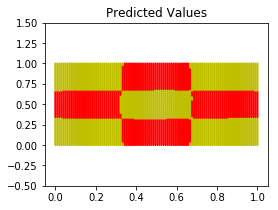

In [6]:
# (*) Step 5: Plotting
# Initialize figiure an axis
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # prob<0.5 --> label -1 // prob>0.5 --> label 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
    # Colors = yellow for 1, red for -1
    color = []
    for i in range(len(pred_labels)):
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    # Plot data a scatter plot
    ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color, s=1)
    ax.set_ylim([-0.5, 1.5])
    ax.set_title(title)
# Plot predictions
ax_plot(observed_ax, observed_pred, 'Predicted Values')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 200,
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GPWrapper),
])

pipe.fit(X=train_x, y=train_y)

  epoch    train_loss     dur
-------  ------------  ------
      1      386.2593  0.8515
      2      132.1532  0.9494
      3       87.2927  0.8463
      4       75.6586  0.8345
      5       64.4967  0.8571
      6       52.8795  0.8878
      7       36.7115  0.8390
      8       26.4053  1.0263
      9       17.5674  0.9819
     10       13.0037  0.9560
     11       10.4763  1.0817
     12        8.4145  0.9868
     13        7.3189  0.8987
     14        6.4830  0.8444
     15        5.8577  0.8474
     16        5.2921  0.8765
     17        4.9967  0.8755
     18        4.5161  1.0906
     19        4.0612  1.2341
     20        3.4626  0.9563
     21        3.4187  1.4757
     22        2.9888  1.1645
     23        2.9279  1.2327
     24        2.7794  1.1040
     25        2.5536  1.1987
     26        2.4978  0.9362
     27        2.4660  1.3754
     28        2.3243  0.9531
     29        2.2057  0.9580
     30        2.2242  1.1164
     31        2.0527  1.1879
     32   

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.VariationalGaussianProcessClassifier'>[initialized](
  module_=GPClassificationModel(
    (mean_module): ConstantMean()
    (covar_module): GridKernel(
      (base_kernel_module): RBFKernel()
    )
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}

GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 200,
)

gs = GridSearchCV(GPWrapper, params, refit=False, cv=3, scoring='accuracy',
                  return_train_score=False)  # Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1      966.8924  1.1913
      2      862.1198  1.2398
      3      769.5782  1.0578
      4      688.9012  1.0580
      5      618.5310  1.2943
      6      557.8286  1.0703
      7      505.2246  1.1415
      8      460.0349  1.3623
      9      421.2902  0.9600
     10      388.3403  0.9571
  epoch    train_loss     dur
-------  ------------  ------
      1      966.9047  1.2005
      2      862.4175  0.9572
      3      770.2535  0.9769
      4      689.5417  0.9778
      5      619.6158  1.1508
      6      558.9026  1.0852
      7      506.4880  0.8752
      8      461.5730  0.8522
      9      423.0173  0.8264
     10      390.1455  1.2654
  epoch    train_loss     dur
-------  ------------  ------
      1      964.2571  1.2524
      2      860.2063  1.0371
      3      768.0756  0.8790
      4      687.5983  0.9071
      5      617.9907  0.8746
      6      557.5901  0.9249
      7      505.8167  1.1984
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`